1. Pad sizes with 8
2. bfloat16 represents the same range as 16
3. Summation, exp, log should use full precision

https://on-demand.gputechconf.com/gtcdc/2019/pdf/dc91247-automatic-mixed-precision-in-tensorflow.pdf
https://www.tensorflow.org/guide/mixed_precision
https://developer.download.nvidia.com/video/gputechconf/gtc/2020/presentations/s21929-tensor-core-performance-on-nvidia-gpus-the-ultimate-guide.pdf
https://pytorch.org/blog/what-every-user-should-know-about-mixed-precision-training-in-pytorch/

In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import flax
import flax.linen as nn


jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')

key = jax.random.PRNGKey(0)

In [2]:
import time

def time_fn(fn, n=5):
    def wrap(*args, **kwargs):
        res = []
        for i in range(n):
            start = time.time()
            out = fn(*args, **kwargs).block_until_ready()
            fin = time.time()
            res.append(fin - start)
        return out, np.mean(res)
    return wrap

In [3]:
from itertools import product

dtypes = (jnp.float64, jnp.float32, jnp.float16, jnp.bfloat16)
dim = 2 ** 13
res = {}
for cdtype, pdtype in product(dtypes, dtypes):
    x = jnp.ones(dim, dtype=cdtype)
    fc = nn.Dense(dim, dtype=cdtype, param_dtype=pdtype)
    params = fc.init(key, x)
    out, long = time_fn(fc.apply)(params,x)
    res[(cdtype, pdtype)] = long

In [102]:
fi = jnp.finfo(jnp.bfloat16)

In [103]:
fi.resolution

0.0100098

In [89]:
def f(x):
    return jnp.log(jnp.exp(x))

In [94]:
f(10000.)

Array(inf, dtype=float64, weak_type=True)

In [95]:
g = jax.jit(f)

In [96]:
g(x)

Array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],      dtype=float32)

In [97]:
jax.make_jaxpr(g)(x)

{ lambda ; a:f32[32]. let
    b:f32[32] = pjit[
      jaxpr={ lambda ; c:f32[32]. let
          d:f32[32] = exp c
          e:f32[32] = log d
        in (e,) }
      name=f
    ] a
  in (b,) }

In [79]:
def f(x):
    return jax.nn.softmax(x.astype(jnp.bfloat16))

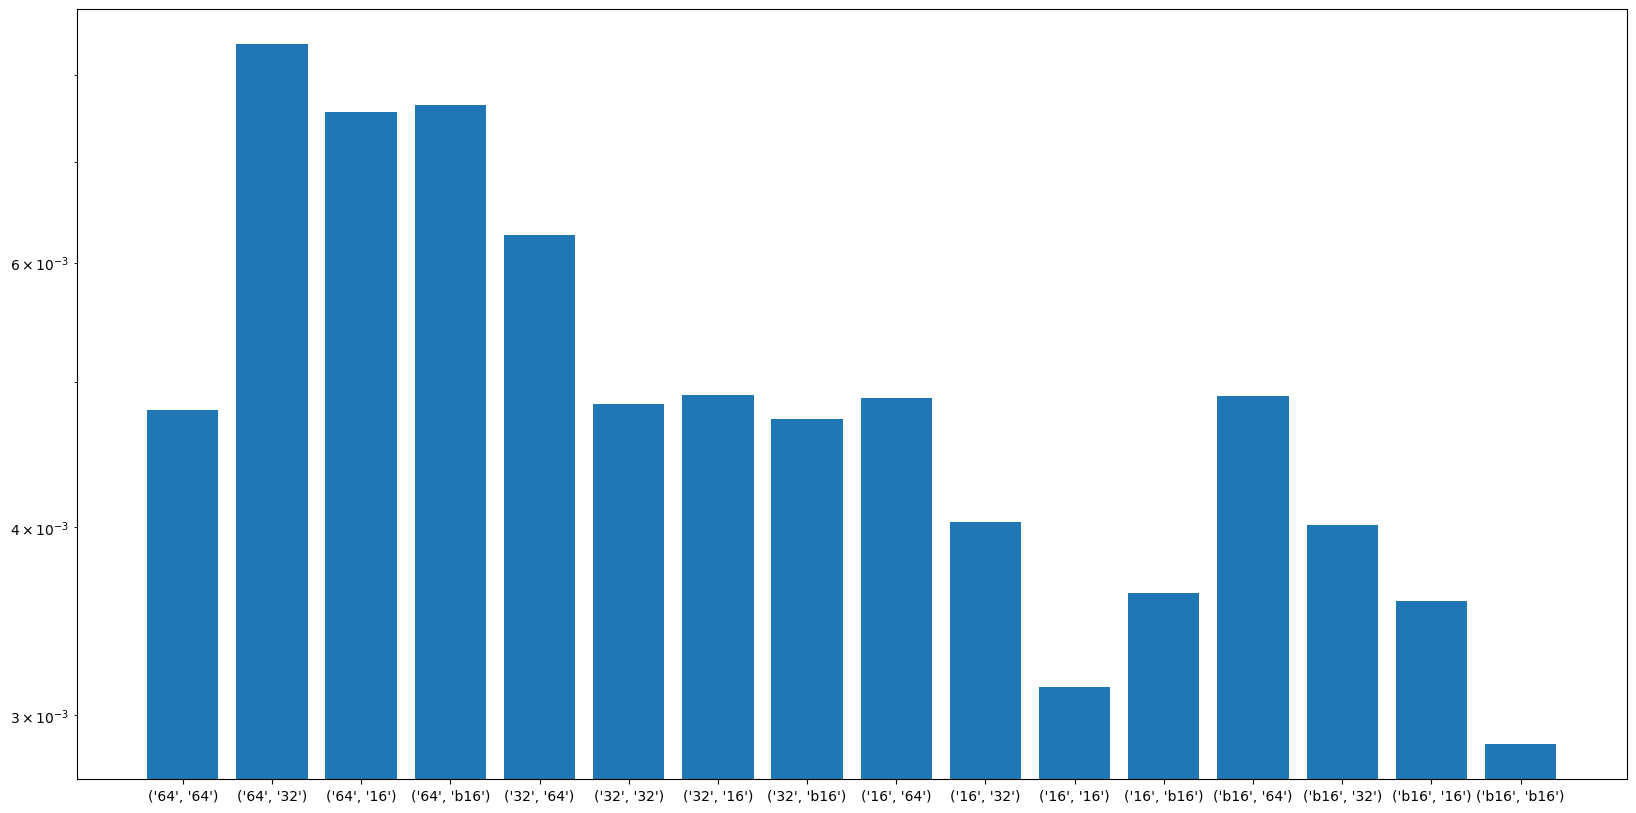

In [9]:
import matplotlib.pyplot as plt
def repr(dtypes):
    c, p = dtypes
    def fn(t): return {jnp.float64: '64', jnp.float32: '32', jnp.float16: '16', jnp.bfloat16: 'b16'}[t]
    return fn(c), fn(p)
plt.figure(figsize=(20, 10))
plt.bar(list(map(lambda x: str(repr(x)), res.keys())), list(res.values()))
plt.yscale('log')